## Heavily adapted from [here](https://github.com/pytorch/examples/blob/master/vae/main.py)

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt

import time
import pickle

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
batch_size=128
epochs = 1000
log_interval = 100
z_dim = 20

In [5]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector -- NOT USED """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2, use only 
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    return I.astype(np.float)

In [6]:
class MixedFrames(torch.utils.data.Dataset):
    """
    A customized data set for pong images.
    """
    def __init__(self, _len):
        """ Intialize the dataset
        """
        #self.filenames = []
        #self.root = root
        self.transform = transforms.ToTensor()
        self.len = _len * 3
        self.obs = []
        
        ## Game1
        env = gym.make("Amidar-v0")
        observation = env.reset()
        for i in range(self.len):
            observation,_,_,_ = env.step(env.action_space.sample())
            self.obs.append(observation)     
                
        ## Game2
        env = gym.make("Assault-v0")
        observation = env.reset()
        for i in range(self.len):
            observation,_,_,_ = env.step(env.action_space.sample())
            self.obs.append(observation)
                
        ## Game3
        env = gym.make("Centipede-v0")
        observation = env.reset()
        for i in range(self.len):
            observation,_,_,_ = env.step(env.action_space.sample())
            self.obs.append(observation)
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = self.obs[index]
        return self.transform(image)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [7]:
def is_in_arr_list(arr, arr_list):
    for element in arr_list:
        if np.array_equal(element, arr):
            return True
        
    return False

In [8]:
class PongFrames(torch.utils.data.Dataset):
    """
    A customized data set for pong images.
    """
    def __init__(self, _len, discard_duplicates=False, preprocess=False):
        """ Intialize the dataset
        """
        #self.filenames = []
        #self.root = root
        self.transform = transforms.ToTensor()
        self.len = _len
        self.obs = []
        env = gym.make("Pong-v0")
        env.reset()
        for i in range(self.len):
            #print(i)
            observation,_,done,_ = env.step(env.action_space.sample())
            if done:
                observation = env.reset()
            present=False
            #self.obs.append(prepro(observation))
            if discard_duplicates:
                while is_in_arr_list(observation, self.obs):
                    #print(i, "repeat")
                    observation,_,done,_ = env.step(env.action_space.sample())
                    if done:
                        observation = env.reset()
            if not preprocess:
                self.obs.append(observation)
            else:
                self.obs.append(prepro(observation))
        #filenames = glob.glob(osp.join(path, '*.jpg'))
        #for fn in filenames:
        #    self.filenames.append(fn)
        #self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = self.obs[index]
        return self.transform(image)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [9]:
use_mixed = False
discard_duplicates = True
preproc = True
n_train_examples = 300
n_test_examples = 450

if not use_mixed:
    ## Set up data set and data loader
    pong_frames = PongFrames(n_train_examples, discard_duplicates=discard_duplicates, preprocess=preproc)
    pong_frames_test = PongFrames(n_test_examples, preprocess=preproc)
    im_dm = pong_frames[0].view(-1).size()[0]

    train_loader = torch.utils.data.DataLoader(
        pong_frames,
        batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        pong_frames_test,
        batch_size=batch_size, shuffle=True)
    
    im_dims = pong_frames[0].size()
else:
    ## Set up data set and data loader (Multiple games: 3)
    mixed_frames = MixedFrames(n_train_examples)
    mixed_frames_test = MixedFrames(n_test_examples)
    im_dm = mixed_frames[0].view(-1).size()[0]

    train_loader = torch.utils.data.DataLoader(
        mixed_frames,
        batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        mixed_frames_test,
        batch_size=batch_size, shuffle=True)
    
    im_dims = mixed_frames[0].size()

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        ## Encode
        self.fce1 = nn.Linear(im_dm, 3200)
        self.fce2 = nn.Linear(3200, 1600)
        self.fce3 = nn.Linear(1600, 800)
        self.fce4 = nn.Linear(800, 400)
        # Sigma2, Mu
        self.fce51 = nn.Linear(400, z_dim)
        self.fce52 = nn.Linear(400, z_dim)
        
        ## Decode
        self.fcd1 = nn.Linear(z_dim, 400)
        self.fcd2 = nn.Linear(400, 800)
        self.fcd3 = nn.Linear(800, 1600)
        self.fcd4 = nn.Linear(1600, 3200)
        self.fcd5 = nn.Linear(3200, im_dm)
        #self.fc4 = nn.Linear(800, 80*80)

    def encode(self, x):
        eh1 = torch.sigmoid(self.fce1(x))
        eh2 = torch.sigmoid(self.fce2(eh1))
        eh3 = torch.sigmoid(self.fce3(eh2))
        eh4 = torch.sigmoid(self.fce4(eh3))
        return self.fce51(eh4), self.fce52(eh4)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        dh1 = torch.sigmoid(self.fcd1(z))
        dh2 = torch.sigmoid(self.fcd2(dh1))
        dh3 = torch.sigmoid(self.fcd3(dh2))
        dh4 = torch.sigmoid(self.fcd4(dh3))
        #return torch.relu(self.fcd5(dh4))
        return torch.sigmoid(self.fcd5(dh4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, im_dm))
        #mu, logvar = self.encode(x.view(-1, 80*80))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(im_dm, 800)
        #self.fc1 = nn.Linear(80*80, 800)
        self.fc21 = nn.Linear(800, z_dim)
        self.fc22 = nn.Linear(800, z_dim)
        self.fc3 = nn.Linear(z_dim, 800)
        self.fc4 = nn.Linear(800, im_dm)
        #self.fc4 = nn.Linear(800, 80*80)

    def encode(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.sigmoid(self.fc3(z))
        return torch.relu(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, im_dm))
        #mu, logvar = self.encode(x.view(-1, 80*80))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

## Test MNIST
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.ToTensor()
                  ),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

im_dm = 28*28
im_dims = torch.tensor([1,28,28])

In [11]:
vae_model = VAE().to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

In [20]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, beta=1):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, im_dm), reduction='sum')
    L1 = F.l1_loss(recon_x, x.view(-1, im_dm))
    #L1 = F.l1_loss(recon_x, x.view(-1, 80*80))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    ## New loss added by Arno. K -- weak guess loss: punish the network for trying to predict all zeros
    WGL = 1 / recon_x.mean()
    
    #print(BCE, KLD)
    #return BCE + beta * KLD    
    return L1 + (beta * KLD) + (0.01 * WGL**0.1)    
    #return L1 + (beta * KLD)

In [21]:
def train(epoch):
    vae_model.train()
    train_loss = 0
    #for batch_idx, (data, _) in enumerate(train_loader):
    for batch_idx, data in enumerate(train_loader):
    #for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device).float()
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta=0.1)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
            r = recon_batch.view(min(batch_size, data.size(0)), im_dims[0], im_dims[1], im_dims[2])
            #print(r[0].cpu().detach().numpy().reshape(im_dims[1], im_dims[2], im_dims[0]).shape)
            plt.imshow(r[0].cpu().detach().numpy().reshape(im_dims[1], im_dims[2]))
            plt.show()

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [22]:
def test(epoch):
    vae_model.eval()
    test_loss = 0
    with torch.no_grad():
        #for i, (data, _) in enumerate(test_loader):
        for i, data in enumerate(test_loader):
        #for i, (data, _) in enumerate(test_loader):
            data = data.to(device).float()
            recon_batch, mu, logvar = vae_model(data)
            #print(data.shape, recon_batch.shape)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                #plt.imshow(data[0].cpu().numpy().reshape(250,160,3))
                #plt.show()
                #comparison = torch.cat([data[:n],recon_batch.view(batch_size, 1, 28, 28)[:n]])
                comparison = torch.cat([data[:n],recon_batch.view(batch_size, im_dims[0], im_dims[1], im_dims[2])[:n]])
                #comparison = torch.cat([data[:n],recon_batch.view(batch_size, 1, 80, 80)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/300 (0%)]	Loss: 0.006356


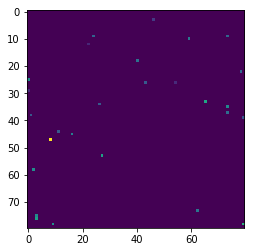

====> Epoch: 1 Average loss: 0.0079
====> Test set loss: 0.1540
Train Epoch: 2 [0/300 (0%)]	Loss: 0.006266


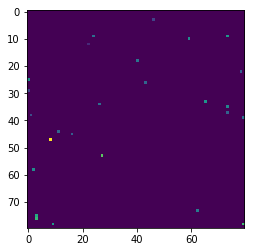

====> Epoch: 2 Average loss: 0.0079
====> Test set loss: 0.1549
Train Epoch: 3 [0/300 (0%)]	Loss: 0.006274


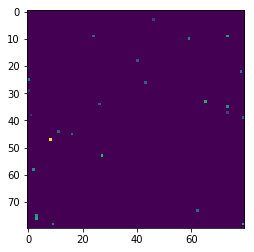

====> Epoch: 3 Average loss: 0.0078
====> Test set loss: 0.1545
Train Epoch: 4 [0/300 (0%)]	Loss: 0.006211


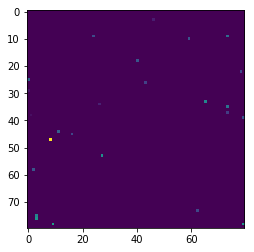

====> Epoch: 4 Average loss: 0.0077
====> Test set loss: 0.1544
Train Epoch: 5 [0/300 (0%)]	Loss: 0.005990


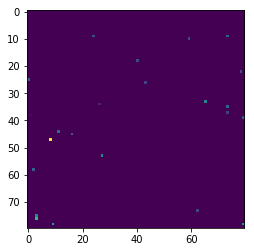

====> Epoch: 5 Average loss: 0.0086
====> Test set loss: 0.1605
Train Epoch: 6 [0/300 (0%)]	Loss: 0.006809


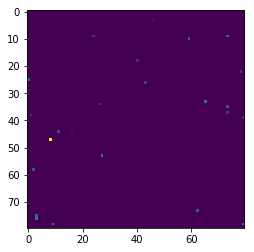

====> Epoch: 6 Average loss: 0.0087
====> Test set loss: 0.1587
Train Epoch: 7 [0/300 (0%)]	Loss: 0.006617


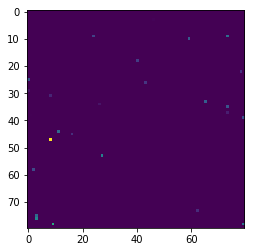

====> Epoch: 7 Average loss: 0.0082
====> Test set loss: 0.1580
Train Epoch: 8 [0/300 (0%)]	Loss: 0.006534


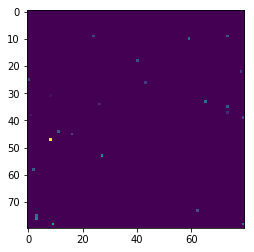

====> Epoch: 8 Average loss: 0.0082
====> Test set loss: 0.1539
Train Epoch: 9 [0/300 (0%)]	Loss: 0.006285


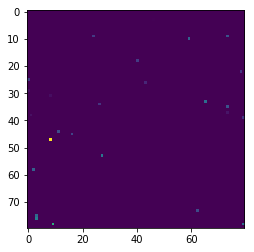

====> Epoch: 9 Average loss: 0.0078
====> Test set loss: 0.1547
Train Epoch: 10 [0/300 (0%)]	Loss: 0.006328


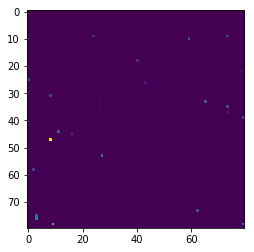

====> Epoch: 10 Average loss: 0.0080
====> Test set loss: 0.1537


In [24]:
## Main
epochs = 10
for epoch in range(1, epochs + 1):
    if epoch == epochs // 2: optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)
    train(epoch)
    test(epoch)
    if epochs % 10 == 0:
        with torch.no_grad():
            sample = torch.randn(64, z_dim).to(device)
            sample = vae_model.decode(sample).cpu()
            #save_image(sample.view(64, 1, 28, 28),'results/sample_' + str(epoch) + '.png')
            save_image(sample.view(64, im_dims[0], im_dims[1], im_dims[2]),'results/sample_' + str(epoch) + '.png')
            #save_image(sample.view(64, 1, 80, 80),'results/sample_' + str(epoch) + '.png')            

In [305]:
a = torch.tensor([1,2])

In [ ]:
a.

## Using Preprocessed frames as input

In [44]:
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 60 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

render = False 
#render = True

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
#while True:
start = time.time()
while(episode_number < 1500):
    if render: env.render()

    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    #print(x.shape)
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was ' + str(reward_sum) + '. running mean: {0:.2f}'.format(running_reward))

        if episode_number % 100 == 0: pickle.dump(model, open('save_prepoc.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None

    #if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        #print ('ep ' + str(episode_number) + ': game finished, reward: ' + str(reward) + ('' if reward == -1 else ' !!!!!!!!'))
        #print(episode_number, reward)

end = time.time()
print(end - start)

resetting env. episode reward total was -21.0. running mean: -21.00
resetting env. episode reward total was -21.0. running mean: -21.00
resetting env. episode reward total was -20.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -20.0. running mean: -20.98
resetting env. episode reward total was -20.0. running mean: -20.97
resetting env. episode reward total was -21.0. running mean: -20.97
resetting env. episode reward total was -20.0. running mean: -20.96
resetting env. episode reward total was -20.0. running mean: -20.95
resetting env. episode reward total was -19.0. running mean: -20.93
resetting env. episode reward total was -20.0. running mean: -20.92
resetting env. episode reward total was -21.0. running mean: -20.92
resetting env. episode reward total was -19.0. r

resetting env. episode reward total was -21.0. running mean: -20.48
resetting env. episode reward total was -20.0. running mean: -20.48
resetting env. episode reward total was -19.0. running mean: -20.46
resetting env. episode reward total was -21.0. running mean: -20.47
resetting env. episode reward total was -21.0. running mean: -20.47
resetting env. episode reward total was -21.0. running mean: -20.48
resetting env. episode reward total was -19.0. running mean: -20.47
resetting env. episode reward total was -21.0. running mean: -20.47
resetting env. episode reward total was -21.0. running mean: -20.48
resetting env. episode reward total was -20.0. running mean: -20.47
resetting env. episode reward total was -21.0. running mean: -20.48
resetting env. episode reward total was -20.0. running mean: -20.47
resetting env. episode reward total was -21.0. running mean: -20.48
resetting env. episode reward total was -20.0. running mean: -20.47
resetting env. episode reward total was -20.0. r

resetting env. episode reward total was -21.0. running mean: -20.50
resetting env. episode reward total was -20.0. running mean: -20.50
resetting env. episode reward total was -19.0. running mean: -20.48
resetting env. episode reward total was -21.0. running mean: -20.49
resetting env. episode reward total was -20.0. running mean: -20.48
resetting env. episode reward total was -21.0. running mean: -20.49
resetting env. episode reward total was -21.0. running mean: -20.49
resetting env. episode reward total was -20.0. running mean: -20.49
resetting env. episode reward total was -21.0. running mean: -20.49
resetting env. episode reward total was -21.0. running mean: -20.50
resetting env. episode reward total was -21.0. running mean: -20.50
resetting env. episode reward total was -20.0. running mean: -20.50
resetting env. episode reward total was -21.0. running mean: -20.50
resetting env. episode reward total was -20.0. running mean: -20.50
resetting env. episode reward total was -21.0. r

KeyboardInterrupt: 

## Using Latent Variables as input

In [71]:
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 60 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

render = False 
#render = True

# model initialization
D = z_dim # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
#while True:
start = time.time()
while(episode_number < 1500):
    if render: env.render()

    # preprocess the observation, set input to network to be difference image
    x = torch.from_numpy(observation).to(device).float()
    mu, logvar = vae_model.encode(x.view(-1, im_dm))
    z = vae_model.reparameterize(mu, logvar)
    cur_x = z
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    if prev_x is not None:
        x = x.cpu().detach().numpy().reshape(-1)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    #print(x.shape)
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was ' + str(reward_sum) + '. running mean: {0:.2f}'.format(running_reward))

        if episode_number % 100 == 0: pickle.dump(model, open('save_prepoc.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None

    #if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        #print ('ep ' + str(episode_number) + ': game finished, reward: ' + str(reward) + ('' if reward == -1 else ' !!!!!!!!'))
        #print(episode_number, reward)

end = time.time()
print(end - start)

resetting env. episode reward total was -21.0. running mean: -21.00
resetting env. episode reward total was -21.0. running mean: -21.00
resetting env. episode reward total was -21.0. running mean: -21.00
resetting env. episode reward total was -21.0. running mean: -21.00
resetting env. episode reward total was -20.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -21.0. running mean: -20.99
resetting env. episode reward total was -20.0. running mean: -20.98
resetting env. episode reward total was -21.0. running mean: -20.98
resetting env. episode reward total was -21.0. running mean: -20.98
resetting env. episode reward total was -20.0. running mean: -20.97
resetting env. episode reward total was -21.0. r

KeyboardInterrupt: 

In [ ]:
plt.imshow(mixed_frames[-200].numpy().reshape(250,160,3))
plt.show()

In [21]:
n = min(data.size(0), 8)

In [25]:
data[:n].numpy().shape

(8, 3, 250, 160)

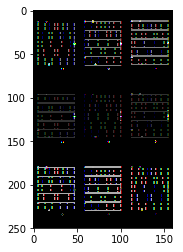

In [26]:
for i, data in enumerate(test_loader):
    data = data.float()
    if i ==0:
        plt.imshow(data[i].numpy().reshape(250,160,3))
        plt.show()

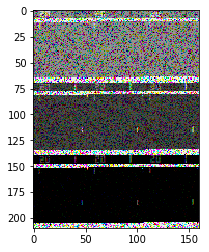

In [58]:
sample = torch.randn(1, z_dim).cuda()
res = model.decode(sample).cpu()
plt.imshow(res.detach().numpy().reshape(210,160,3))
plt.show()

In [ ]:

for i, data in enumerate(train_loader):
    data = data.float()
    #print(i)
    if i > 200 and i < 205:
        plt.imshow(data[2].numpy().reshape(250,160,3))
        plt.show()

In [ ]:
train_loader

In [ ]:
len(train_loader) * batch_size